In [1]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error,mean_absolute_error, mean_absolute_percentage_error
import numpy as np
import itertools
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import performance_metrics
from prophet.diagnostics import cross_validation

In [2]:
df=pd.read_csv('product i.csv', parse_dates=['Month-Year'])

In [3]:
sales_i= df.drop(['Product Name','Product Category','Month','Year','Market Size', 'Marketing Expense','Month No.'],axis=1)

In [4]:
sales_i.shape

(60, 2)

In [5]:
sales_i.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Month-Year  60 non-null     datetime64[ns]
 1   Sales       60 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.1 KB


In [6]:
sales_i['Sales'].sum()

5783407

In [7]:
sales_i = sales_i.rename(columns={'Month-Year': 'ds',
                        'Sales': 'y'})

sales_i.head()

ds      y
0 2019-01-01  50833
1 2019-02-01  65670
2 2019-03-01  89667
3 2019-04-01  60960
4 2019-05-01  43410

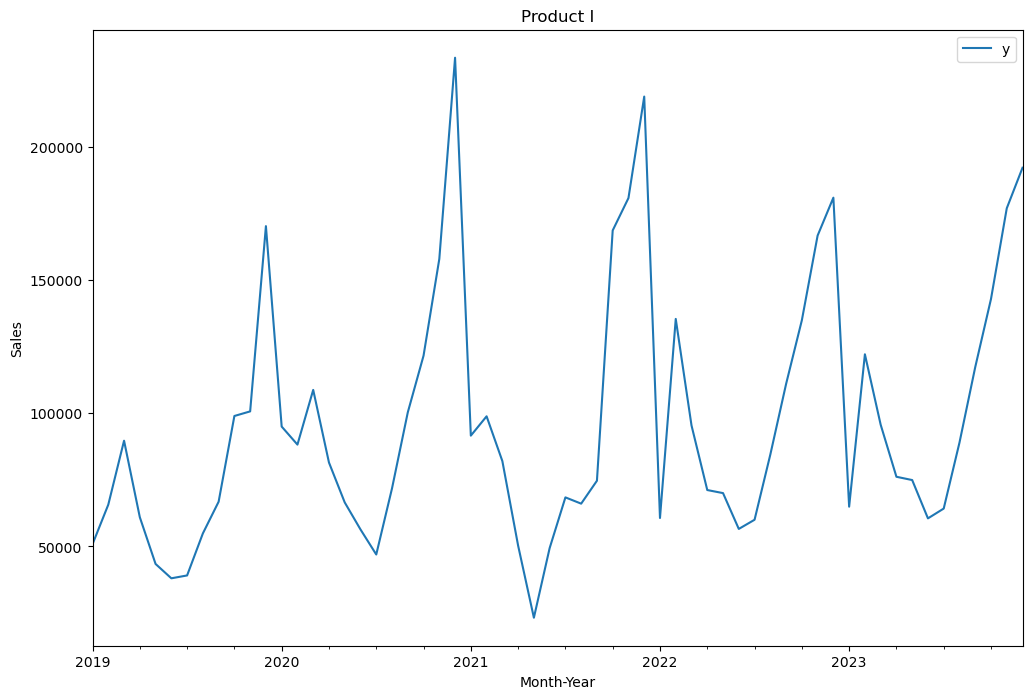

In [8]:
ax = sales_i.set_index('ds').plot(figsize=(12, 8))
ax.set_ylabel('Sales')
ax.set_xlabel('Month-Year')
plt.title('Product I')
plt.show()

In [9]:
from statsmodels.tsa.stattools import adfuller

In [10]:
def adf_test(series):
    result=adfuller(series)
    print('ADF Statistics: {}'.format(result[0]))
    print('p- value: {}'.format(result[1]))
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [11]:
adf_test(sales_i['y'])

ADF Statistics: -2.5790376657087335
p- value: 0.09740761251652458
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [12]:
train= sales_i[:54]
test=sales_i[54:]

# Hyperparameter Tuning

In [13]:
changepoint_prior_scale_range = [0.001, 0.01, 0.1,0.2, 0.3, 0.5]
seasonality_prior_scale_range = [0.01, 0.1, 1.0, 3.0, 5.0, 10.0]
seasonality_mode_range = ['additive', 'multiplicative']

param_grid = {  
    'changepoint_prior_scale': changepoint_prior_scale_range,
    'seasonality_prior_scale': seasonality_prior_scale_range,
    'seasonality_mode' : seasonality_mode_range
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(train)  # Fit model with given params
    df_cv = cross_validation(m, initial='730 days', period='365 days', horizon = '180 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

10:10:23 - cmdstanpy - INFO - Chain [1] start processing
10:10:24 - cmdstanpy - INFO - Chain [1] done processing
10:10:27 - cmdstanpy - INFO - Chain [1] start processing
10:10:27 - cmdstanpy - INFO - Chain [1] done processing
10:10:31 - cmdstanpy - INFO - Chain [1] start processing
10:10:31 - cmdstanpy - INFO - Chain [1] done processing
10:10:34 - cmdstanpy - INFO - Chain [1] start processing
10:10:34 - cmdstanpy - INFO - Chain [1] done processing
10:10:37 - cmdstanpy - INFO - Chain [1] start processing
10:10:38 - cmdstanpy - INFO - Chain [1] done processing
10:10:41 - cmdstanpy - INFO - Chain [1] start processing
10:10:42 - cmdstanpy - INFO - Chain [1] done processing
10:10:45 - cmdstanpy - INFO - Chain [1] start processing
10:10:45 - cmdstanpy - INFO - Chain [1] done processing
10:10:49 - cmdstanpy - INFO - Chain [1] start processing
10:10:49 - cmdstanpy - INFO - Chain [1] done processing
10:10:53 - cmdstanpy - INFO - Chain [1] start processing
10:10:53 - cmdstanpy - INFO - Chain [1]

    changepoint_prior_scale  seasonality_prior_scale seasonality_mode  \
0                     0.001                     0.01         additive   
1                     0.001                     0.01   multiplicative   
2                     0.001                     0.10         additive   
3                     0.001                     0.10   multiplicative   
4                     0.001                     1.00         additive   
..                      ...                      ...              ...   
67                    0.500                     3.00   multiplicative   
68                    0.500                     5.00         additive   
69                    0.500                     5.00   multiplicative   
70                    0.500                    10.00         additive   
71                    0.500                    10.00   multiplicative   

            rmse  
0   47806.618049  
1   49892.973492  
2   21418.503326  
3   23041.191938  
4   20645.360617  
..       

In [14]:
tuning_results.sort_values('rmse',ascending=True)

changepoint_prior_scale  seasonality_prior_scale seasonality_mode  \
44                      0.2                     5.00         additive   
42                      0.2                     3.00         additive   
40                      0.2                     1.00         additive   
46                      0.2                    10.00         additive   
38                      0.2                     0.10         additive   
..                      ...                      ...              ...   
25                      0.1                     0.01   multiplicative   
37                      0.2                     0.01   multiplicative   
61                      0.5                     0.01   multiplicative   
49                      0.3                     0.01   multiplicative   
60                      0.5                     0.01         additive   

            rmse  
44  19444.258269  
42  19499.814672  
40  19542.774933  
46  19601.066223  
38  19739.157389  
..           ...  
25  51580.537007  
37  51605.127530  
61  51644.919253  
49  51723.530802  
60  54937.671467  

[72 rows x 4 columns]

In [37]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 5.0, 'seasonality_mode': 'additive'}


In [38]:
# Create a Prophet model
model = Prophet( changepoint_prior_scale= 0.2,seasonality_prior_scale=5.0, seasonality_mode = 'additive',
                interval_width=0.95)

In [39]:
model.fit(train)

10:16:45 - cmdstanpy - INFO - Chain [1] start processing
10:16:45 - cmdstanpy - INFO - Chain [1] done processing


In [40]:
len(test)

6

In [41]:
# Create a DataFrame for future dates (including 2023)
future_dates = model.make_future_dataframe(periods=len(test), freq='MS')  # 12 months in 2023

In [42]:
# Make predictions for the future
forecast = model.predict(future_dates)

In [43]:
forecasted_df=forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(6)

In [44]:
forecasted_df

ds           yhat     yhat_lower     yhat_upper
54 2023-07-01   65930.696437   37268.873251   95389.310112
55 2023-08-01   85335.612277   56788.458264  115413.930826
56 2023-09-01  104150.588351   73980.499640  133514.533310
57 2023-10-01  144954.882519  114897.733349  175215.835340
58 2023-11-01  154406.668424  123624.463308  183711.126253
59 2023-12-01  196899.328198  167705.461890  224934.165770

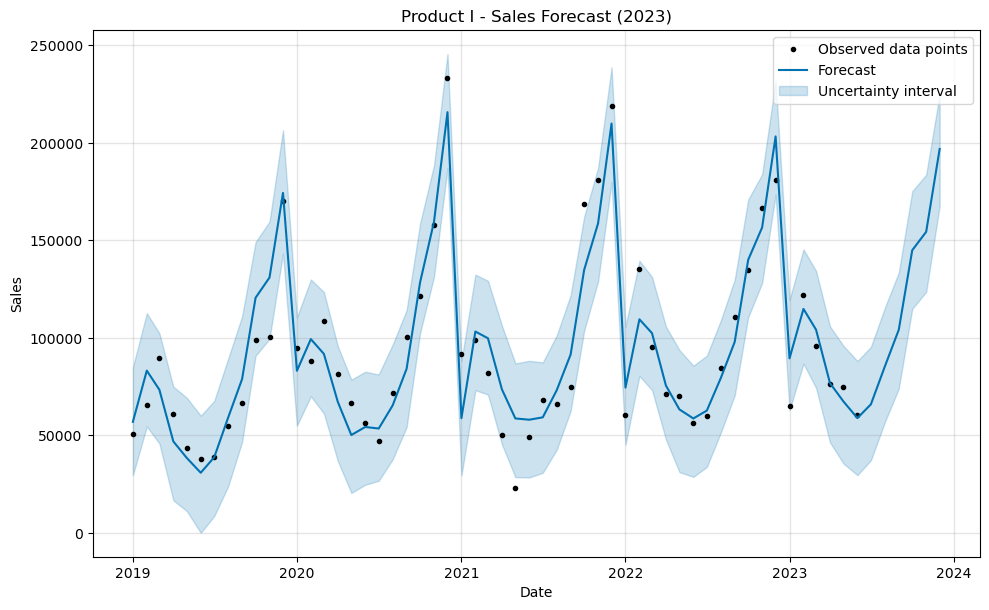

In [45]:
fig = model.plot(forecast, include_legend=True, uncertainty=True)
plt.title('Product I - Sales Forecast (2023)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

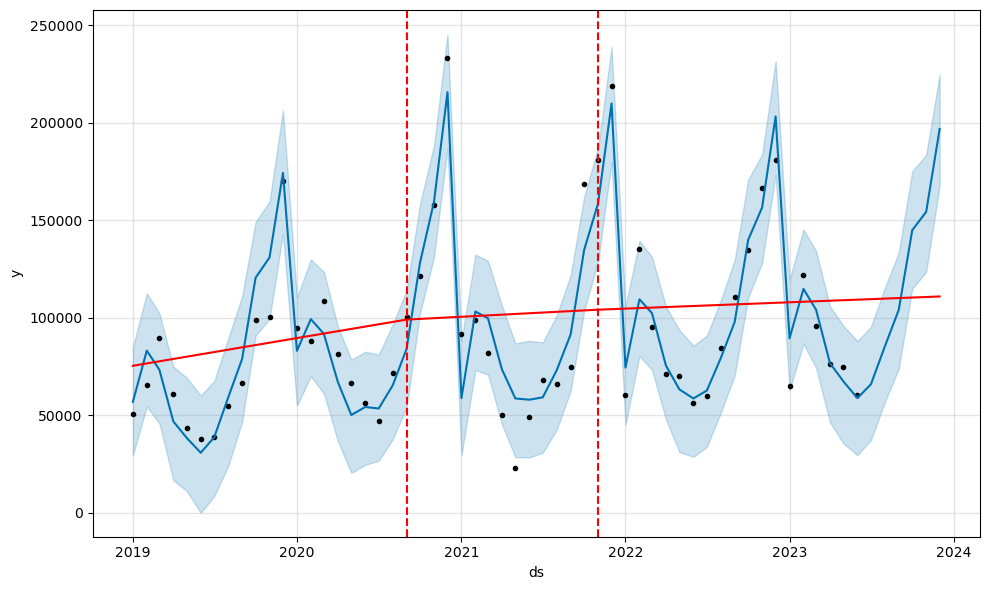

In [46]:
from prophet.plot import add_changepoints_to_plot
fig = model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model, forecast)

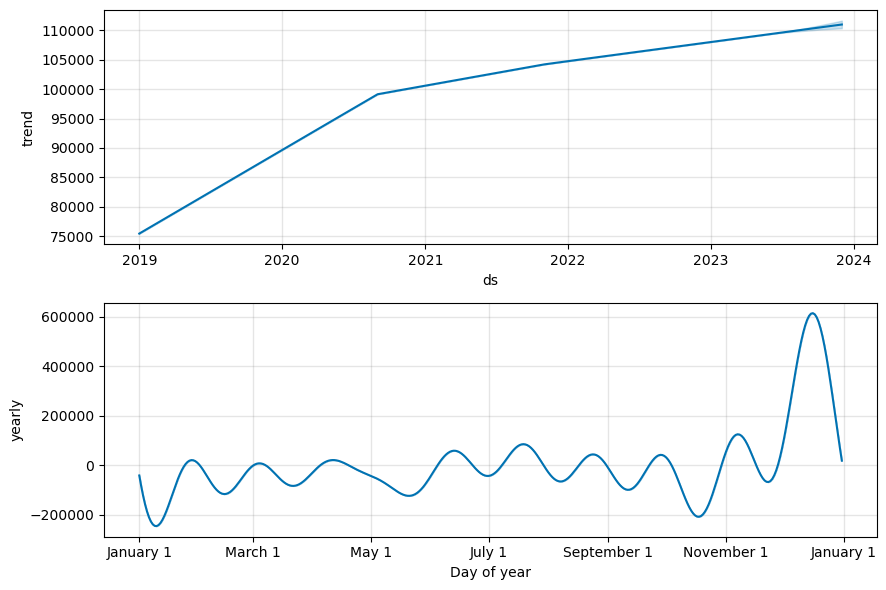

In [47]:
fig2 = model.plot_components(forecast)

In [48]:
forecasted_df

ds           yhat     yhat_lower     yhat_upper
54 2023-07-01   65930.696437   37268.873251   95389.310112
55 2023-08-01   85335.612277   56788.458264  115413.930826
56 2023-09-01  104150.588351   73980.499640  133514.533310
57 2023-10-01  144954.882519  114897.733349  175215.835340
58 2023-11-01  154406.668424  123624.463308  183711.126253
59 2023-12-01  196899.328198  167705.461890  224934.165770

In [49]:
sales_i.tail(6) 

ds       y
54 2023-07-01   64200
55 2023-08-01   88953
56 2023-09-01  117297
57 2023-10-01  142882
58 2023-11-01  176896
59 2023-12-01  192123

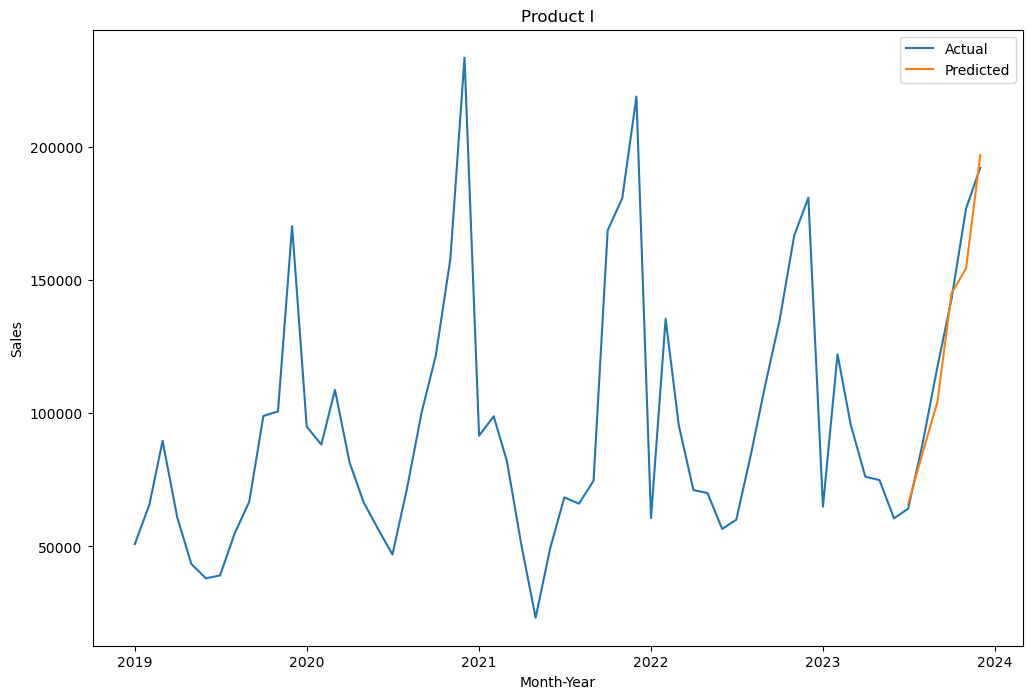

In [50]:
# Reset index of sales_b DataFrame
sales_i_reset_index = sales_i.reset_index()

# Plotting
plt.figure(figsize=(12, 8))
plt.plot(sales_i_reset_index['ds'], sales_i_reset_index['y'], label='Actual')
plt.plot(forecasted_df['ds'], forecasted_df['yhat'], label='Predicted')
plt.title('Product I')
plt.xlabel('Month-Year')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [51]:
#model evaluation

In [52]:
pred=forecasted_df['yhat']
test_df=test['y']

In [53]:
mae_fb= mean_absolute_error(test_df,pred)
mse_fb=mean_squared_error(test_df, pred)
mape_fb= mean_absolute_percentage_error(test_df,pred)
rmse_fb= np.sqrt(mean_squared_error(test_df,pred))


print(f'MAE - FB PROPHET: {mae_fb:.3f}')
print(f'MAPE - FB PROPHET: {mape_fb:.3f}')
print(f'MSE - FB PROPHET: {mse_fb:.3f}')
print(f'RMSE - FB PROPHET: {rmse_fb:.3f}')

MAE - FB PROPHET: 7972.173
MAPE - FB PROPHET: 0.058
MSE - FB PROPHET: 120298188.514
RMSE - FB PROPHET: 10968.053


In [54]:
# train data: 0 to 47 --> Jan-2019 to Dec-2022
# test data: 48: 59 --> Jan 2023 to Dec-2023

#sales_b['y'].plot(figsize=(12,8))
#forecast_df['yhat'].plot()
#plt.title('Product B')
#plt.xlabel('Month')
#plt.ylabel('Sales')
#plt.legend(labels=['Actual', 'Predicted'])
#plt.show()

# Cross Validation

In [55]:
#Set initial window to 2 years (24 months), period to 1 year (12 months), and horizon to 1 year (12 months)
df_cv = cross_validation(model, initial='730 days', period='180 days', horizon='180 days', parallel="processes")

In [56]:
df_p = performance_metrics(df_cv)
df_p

horizon           mse          rmse           mae      mape     mdape  \
0   24 days  2.217072e+09  47085.791280  45810.874693  0.702346  0.702346   
1   25 days  6.540012e+08  25573.447858  22155.317960  0.366088  0.366088   
2   29 days  6.376118e+08  25250.976673  21919.103821  0.343615  0.343615   
3   51 days  1.493399e+09  38644.515457  38438.701664  0.586595  0.586595   
4   55 days  1.360389e+09  36883.457749  36386.296646  0.433263  0.433263   
5   56 days  4.619620e+08  21493.301819  16004.756940  0.121913  0.121913   
6   60 days  2.540176e+07   5040.015615   4295.330076  0.038206  0.038206   
7   82 days  7.555058e+08  27486.465177  22590.312744  0.284598  0.284598   
8   83 days  9.501181e+08  30823.985146  29579.908197  0.365814  0.365814   
9   87 days  3.019076e+08  17375.487327  16908.068107  0.167757  0.167757   
10  88 days  2.188990e+08  14795.236811  14687.468537  0.144220  0.144220   
11 112 days  6.972682e+09  83502.583855  66703.144022  0.432867  0.432867   
12 114 days  6.932367e+09  83260.839913  65371.632788  0.443824  0.443824   
13 117 days  1.773346e+08  13316.704332  13307.328750  0.144505  0.144505   
14 119 days  8.962687e+07   9467.146624   8354.254928  0.073100  0.073100   
15 143 days  6.498338e+09  80612.268274  58918.502117  0.340812  0.340812   
16 144 days  6.506801e+09  80664.741491  59802.784604  0.355689  0.355689   
17 148 days  5.800248e+07   7615.936019   7413.526254  0.067970  0.067970   
18 149 days  8.505008e+07   9222.260096   9222.035622  0.089467  0.089467   
19 173 days  3.391928e+09  58240.257655  45562.679354  0.248981  0.248981   
20 175 days  3.411981e+09  58412.164585  46539.622164  0.286357  0.286357   
21 178 days  7.475457e+08  27341.282472  24118.429398  0.201631  0.201631   
22 180 days  6.851027e+08  26174.465717  19101.918379  0.112238  0.112238   

       smape  coverage  
0   0.931326       0.0  
1   0.296060       0.5  
2   0.282271       0.5  
3   0.682871       0.0  
4   0.599365       0.0  
5   0.136162       0.5  
6   0.039133       1.0  
7   0.373683       0.5  
8   0.443243       0.5  
9   0.160521       1.0  
10  0.140990       1.0  
11  0.610172       0.5  
12  0.619368       0.5  
13  0.133772       1.0  
14  0.070308       1.0  
15  0.485245       0.5  
16  0.502471       0.5  
17  0.070455       1.0  
18  0.094340       1.0  
19  0.296085       0.5  
20  0.320383       0.5  
21  0.183162       0.5  
22  0.102652       0.5

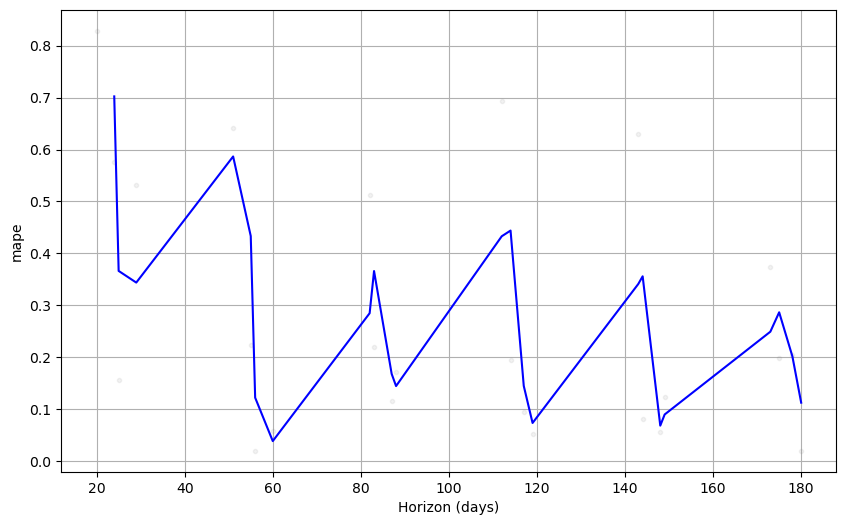

In [57]:
fig = plot_cross_validation_metric(df_cv, metric='mape')

In [58]:
test_df

54     64200
55     88953
56    117297
57    142882
58    176896
59    192123
Name: y, dtype: int64

In [59]:
pred

54     65930.696437
55     85335.612277
56    104150.588351
57    144954.882519
58    154406.668424
59    196899.328198
Name: yhat, dtype: float64

# FORECASTING

In [60]:
model_forecast = Prophet( changepoint_prior_scale= 0.2,seasonality_prior_scale=5.0, seasonality_mode = 'additive',
                interval_width=0.95)

In [61]:
model_forecast.fit(sales_i)

10:16:59 - cmdstanpy - INFO - Chain [1] start processing
10:16:59 - cmdstanpy - INFO - Chain [1] done processing


In [62]:
# Create a DataFrame for future dates 
future_dates_f = model_forecast.make_future_dataframe(periods=6, freq='MS')  # 6 months in 2024

In [63]:
# Make predictions for the future
forecast_f = model_forecast.predict(future_dates_f)

In [64]:
forecasted_f_df=forecast_f[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(6)

In [65]:
forecasted_f_df

ds           yhat    yhat_lower     yhat_upper
60 2024-01-01  107132.556015  78085.867682  137064.223371
61 2024-02-01  123219.942887  95827.638599  150822.378069
62 2024-03-01  114142.157475  86110.773525  141809.854283
63 2024-04-01   88655.435641  60874.761456  116314.086673
64 2024-05-01   71062.737086  41146.556920   99745.139377
65 2024-06-01   74770.973622  46396.454015  103908.122062

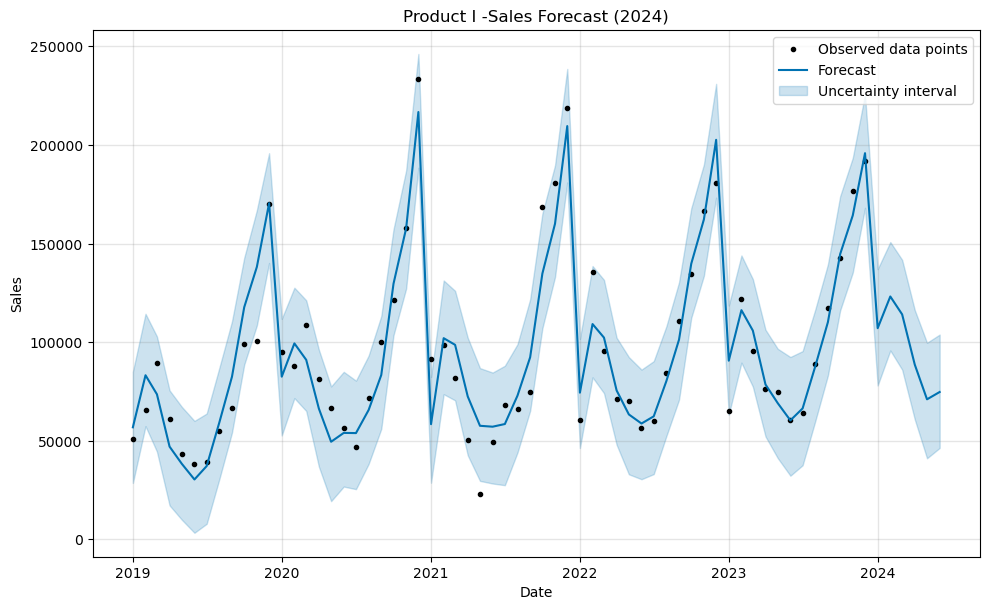

In [66]:
fig = model_forecast.plot(forecast_f, include_legend=True, uncertainty=True)
plt.title('Product I -Sales Forecast (2024)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

In [67]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(model_forecast,forecast_f)

In [68]:
plot_components_plotly(model_forecast, forecast_f)